### Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob

In [3]:
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib import style
from tqdm import tqdm

In [4]:
import os
import random
import re

In [5]:
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
from chess_positions import Check
from chess_positions import IllegalPosition

In [7]:
style.use(style='seaborn-deep')

### Data

In [8]:
tr_path = "./dataset/train"
te_path = "./dataset/test"

In [9]:
tr_images = glob(pathname=(tr_path + '/*jpeg'))
te_images = glob(pathname=(te_path + '/*jpeg'))

In [10]:
tr_labels = list(map(lambda x: os.path.basename(x).split('.')[0].replace('-', '/'), tr_images))
te_labels = list(map(lambda x: os.path.basename(x).split('.')[0].replace('-', '/'), te_images))

In [11]:
tr_df = pd.DataFrame(data={'image': tr_images, 'label': tr_labels})
te_df = pd.DataFrame(data={'image': te_images, 'label': te_labels})

In [12]:
display(tr_df.head())

image  \
0  ./dataset/train/1B1B1K2-3p1N2-6k1-R7-5P2-4q3-7...   
1  ./dataset/train/1B1B1N2-1r6-n2R2k1-7b-1B6-8-8-...   
2  ./dataset/train/1B1B4-1Bp2k2-1K5p-4q3-Nqp4n-3B...   
3  ./dataset/train/1B1B4-1n2bBR1-1P6-n1K2p2-3Rr3-...   
4  ./dataset/train/1B1B4-1r6-5R2-8-6k1-P2b2p1-1r2...   

                                      label  
0       1B1B1K2/3p1N2/6k1/R7/5P2/4q3/7R/1B6  
1         1B1B1N2/1r6/n2R2k1/7b/1B6/8/8/Kn6  
2   1B1B4/1Bp2k2/1K5p/4q3/Nqp4n/3B4/5B2/6r1  
3  1B1B4/1n2bBR1/1P6/n1K2p2/3Rr3/8/2n1k3/b7  
4        1B1B4/1r6/5R2/8/6k1/P2b2p1/1r2K3/8

In [13]:
display(te_df.head())

image  \
0  ./dataset/test/1B1B2K1-1B6-5N2-6k1-8-8-8-4nq2....   
1  ./dataset/test/1B1B3R-8-1b2k3-8-2n5-1rK5-b7-8....   
2  ./dataset/test/1B1B4-4R3-2R2p2-K7-8-3b3r-2Q4P-...   
3  ./dataset/test/1B1BK3-7b-3Np3-4N3-2p1r2P-2r5-8...   
4     ./dataset/test/1B1K3k-8-8-2r4R-2b5-8-7b-8.jpeg   

                                  label  
0        1B1B2K1/1B6/5N2/6k1/8/8/8/4nq2  
1        1B1B3R/8/1b2k3/8/2n5/1rK5/b7/8  
2   1B1B4/4R3/2R2p2/K7/8/3b3r/2Q4P/R2k4  
3  1B1BK3/7b/3Np3/4N3/2p1r2P/2r5/8/5k1b  
4            1B1K3k/8/8/2r4R/2b5/8/7b/8

### Exploratory data analysis

Schema of the train and test dataset

In [14]:
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   80000 non-null  object
 1   label   80000 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [15]:
te_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   20000 non-null  object
 1   label   20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


Check for duplicates

In [16]:
display(any(tr_df.duplicated(subset=['label'])))

False

In [17]:
display(any(te_df.duplicated(subset=['label'])))

False

Total pieces (by type) and total pieces used across all the boards

In [18]:
piece_symbols = 'prbnkqPRBNKQ'

In [19]:
def construct_piece_df(source_df, piece_symbols=piece_symbols):
    """
    This function constructs a peice dataframe for 
    an exploratory data analysis.
    """
    piece_df = pd.DataFrame()
    piece_df['label'] = source_df['label'].values
    for piece in piece_symbols:
        piece_df[piece] = piece_df['label'].apply(lambda x: x.count(piece))
    return piece_df

In [20]:
tr_piece_df = construct_piece_df(source_df=tr_df)
te_piece_df = construct_piece_df(source_df=te_df)

In [21]:
display(tr_piece_df.describe().T)

count      mean       std  min  25%  50%  75%  max
p  80000.0  0.900763  0.963056  0.0  0.0  1.0  1.0  7.0
r  80000.0  0.886550  0.953711  0.0  0.0  1.0  1.0  7.0
b  80000.0  0.885713  0.951939  0.0  0.0  1.0  1.0  6.0
n  80000.0  0.888600  0.953245  0.0  0.0  1.0  1.0  7.0
k  80000.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
q  80000.0  0.444225  0.669567  0.0  0.0  0.0  1.0  6.0
P  80000.0  0.899900  0.955781  0.0  0.0  1.0  1.0  7.0
R  80000.0  0.887262  0.954890  0.0  0.0  1.0  1.0  7.0
B  80000.0  0.879537  0.951519  0.0  0.0  1.0  1.0  8.0
N  80000.0  0.888675  0.958707  0.0  0.0  1.0  1.0  7.0
K  80000.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
Q  80000.0  0.444100  0.672091  0.0  0.0  0.0  1.0  6.0

In [22]:
display(te_piece_df.describe().T)

count     mean       std  min  25%  50%  75%  max
p  20000.0  0.89650  0.953380  0.0  0.0  1.0  1.0  7.0
r  20000.0  0.89445  0.957839  0.0  0.0  1.0  1.0  6.0
b  20000.0  0.88475  0.943987  0.0  0.0  1.0  1.0  6.0
n  20000.0  0.88140  0.950778  0.0  0.0  1.0  1.0  6.0
k  20000.0  1.00000  0.000000  1.0  1.0  1.0  1.0  1.0
q  20000.0  0.43840  0.663044  0.0  0.0  0.0  1.0  5.0
P  20000.0  0.90595  0.969924  0.0  0.0  1.0  1.0  7.0
R  20000.0  0.87680  0.956957  0.0  0.0  1.0  1.0  6.0
B  20000.0  0.88500  0.949642  0.0  0.0  1.0  1.0  6.0
N  20000.0  0.88030  0.945101  0.0  0.0  1.0  1.0  6.0
K  20000.0  1.00000  0.000000  1.0  1.0  1.0  1.0  1.0
Q  20000.0  0.43925  0.661461  0.0  0.0  0.0  1.0  6.0

In [23]:
def chess_piece_distribution(df, col, title):
    """
    This function plots the distribution of given data[label].
    """
    plt.figure(figsize=(15, 8))
    bars = sns.barplot(x=df.index, y=df[col])
    for b in bars.patches:
        x = b.get_x() + (b.get_width() / 2)
        y = b.get_height()
        bars.annotate(text=format(y),
                      xy=(x, y), ha='center', va='center', size=8, 
                      xytext=(0, 6), textcoords='offset points')
    plt.title(label='{} Chess Piece Distribution'.format(title), fontsize=10)
    plt.show()

In [24]:
tr_chess_total_piece_wise = tr_piece_df[list(piece_symbols)].sum().to_frame().rename(columns={0: 'Total Piece-Wise'})

In [25]:
te_chess_total_piece_wise = te_piece_df[list(piece_symbols)].sum().to_frame().rename(columns={0: 'Total Piece-Wise'})

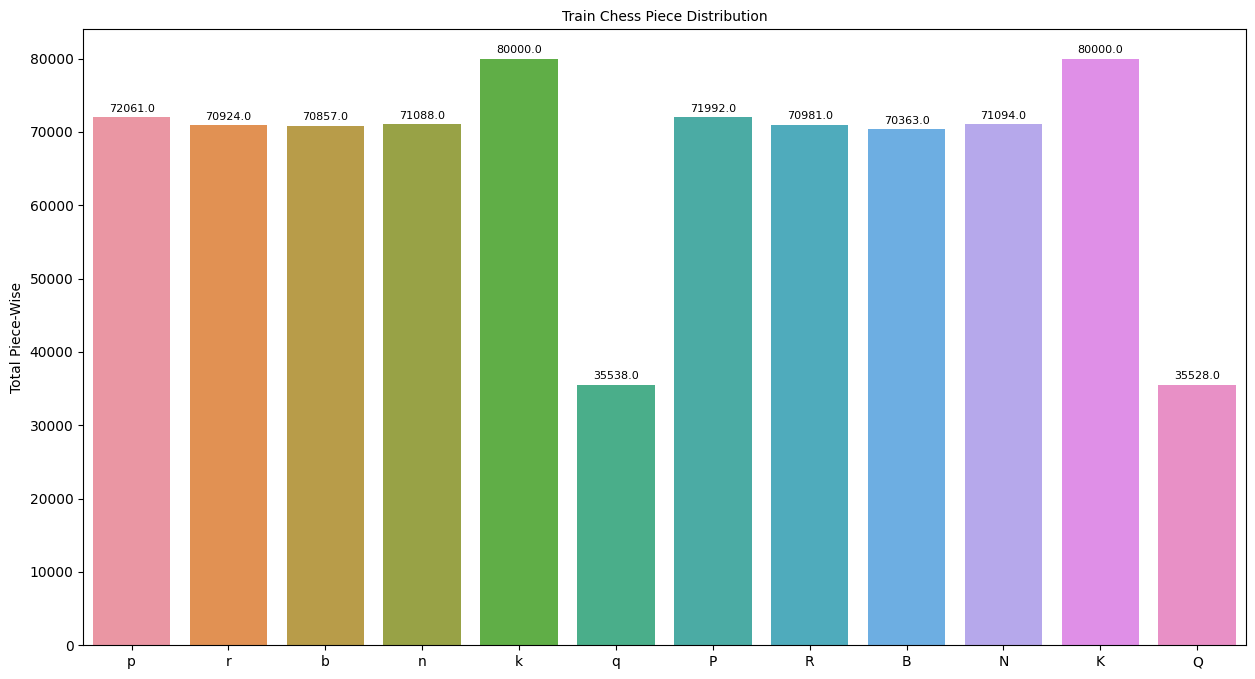

In [26]:
chess_piece_distribution(df=tr_chess_total_piece_wise, col='Total Piece-Wise', title='Train')

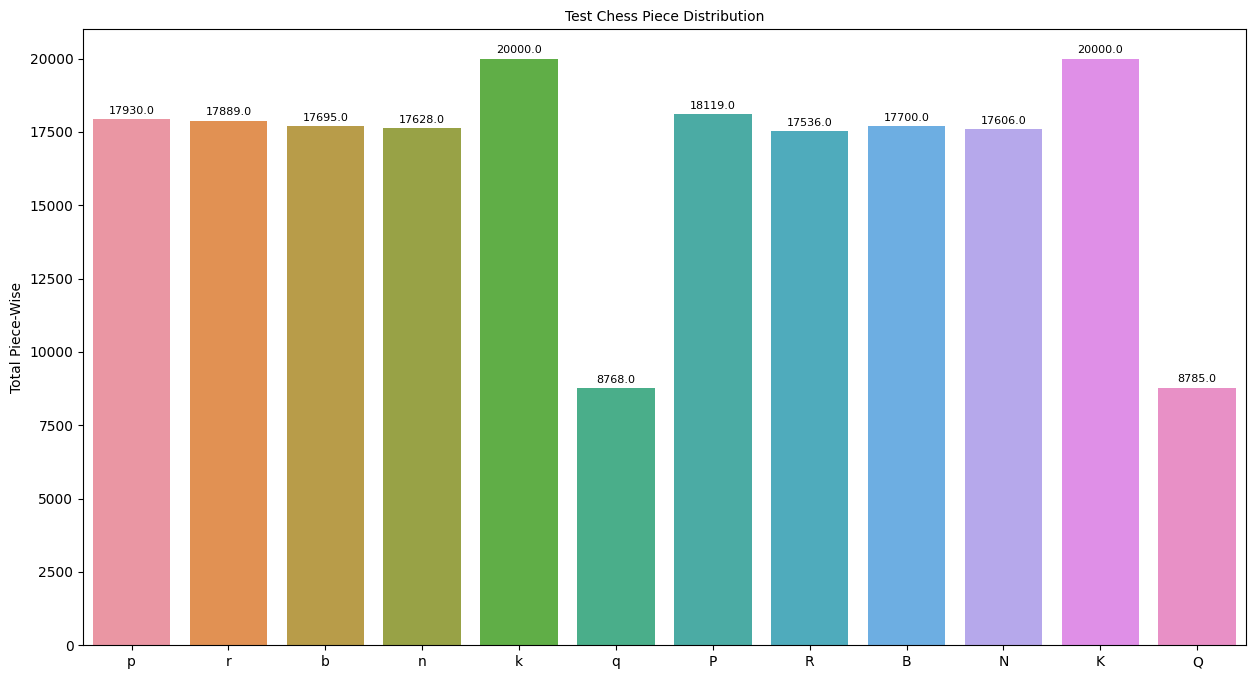

In [27]:
chess_piece_distribution(df=te_chess_total_piece_wise, col='Total Piece-Wise', title='Test')

Conclusion of above chess piece distribution plots:

1. Neither train set nor test set has a total of 8 pawns (white and black) in the boards.
2. There is one and only one king (white and black) in each board, which is legit.
3. Queens are the least used pieces in both train and test sets.

In [28]:
def box_plotter(df, features):
    """
    This is funtion helps in plotting the boxplot of data.
    """
    fig = plt.figure(figsize=(20, 8))
    for (i, feature) in zip(range(1, len(features)+1), features):
        fig.add_subplot(2, 6, i)
        sns.boxplot(y=feature, data=df, width=0.5, flierprops={'marker': 'x'}, color='goldenrod')
        plt.title(label='Boxplot of {}'.format(feature), fontsize=10)
        plt.xlabel(xlabel=None)
        plt.ylabel(ylabel=None)
        plt.grid()
        plt.tight_layout()
        i += 1
    plt.show()

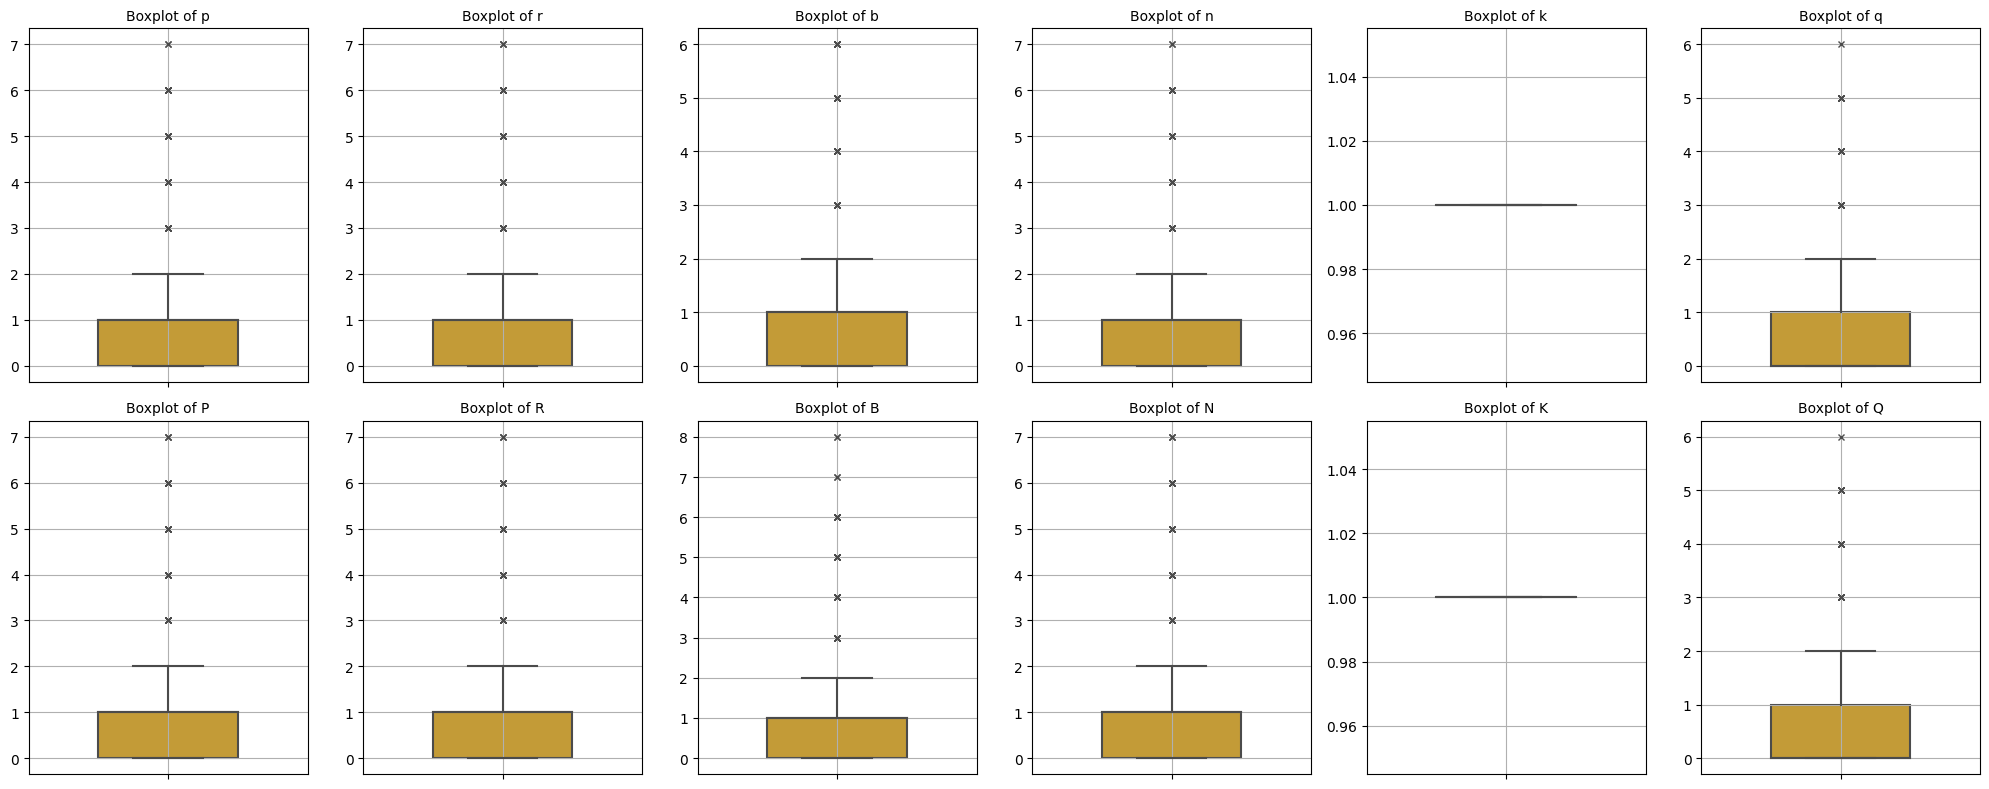

In [29]:
box_plotter(df=tr_piece_df, features=list(piece_symbols))

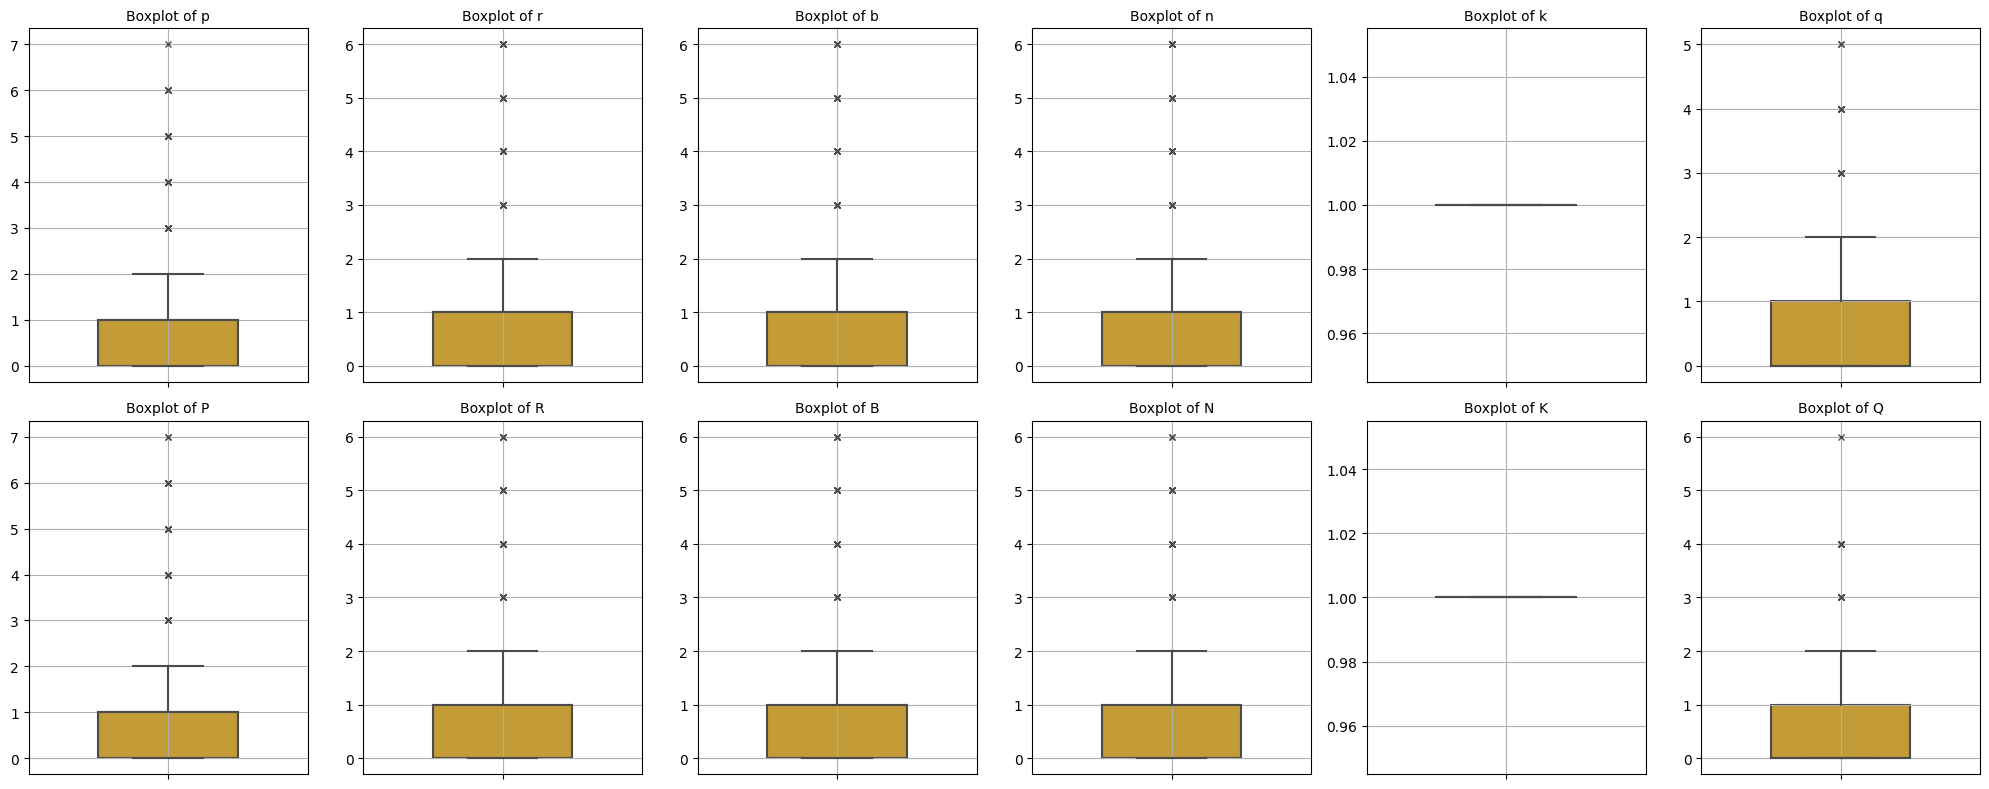

In [30]:
box_plotter(df=te_piece_df, features=list(piece_symbols))

Conclusion of above box plots:
1. There is only 1 Black king and 1 White King in all the boards. Hence min, max, q1, q2, q3 for equal to 1 for k and K box plots.
2. For all other plots - min, q1, and q2 are almost same.

In [31]:
def pdf_plotter(df, features):
    """
    This is funtion helps in plotting the boxplot of data.
    """
    fig = plt.figure(figsize=(20, 8))
    for (i, feature) in zip(range(1, len(features)+1), features):
        fig.add_subplot(2, 6, i)
        sns.kdeplot(data=df, x=feature, shade=True, color='darkorchid')
        plt.title(label='PDF of {}'.format(feature), fontsize=10)
        plt.xlabel(xlabel=None)
        plt.ylabel(ylabel=None)
        plt.grid()
        plt.tight_layout()
        i += 1
    plt.show()

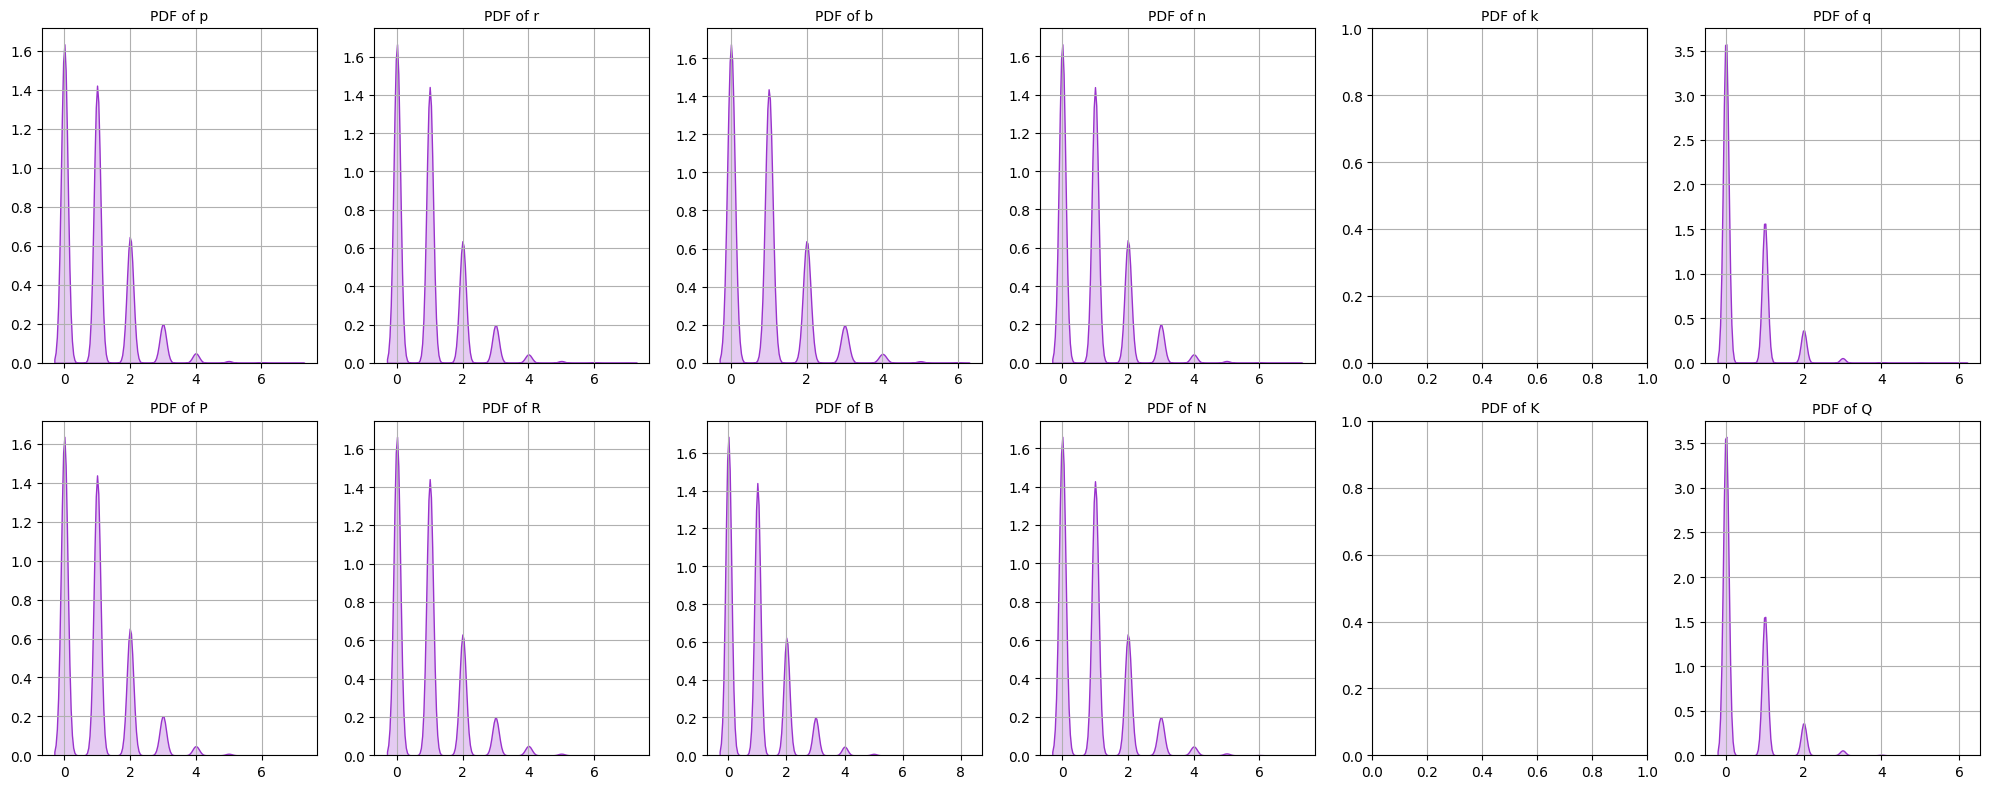

In [32]:
pdf_plotter(df=tr_piece_df, features=list(piece_symbols))

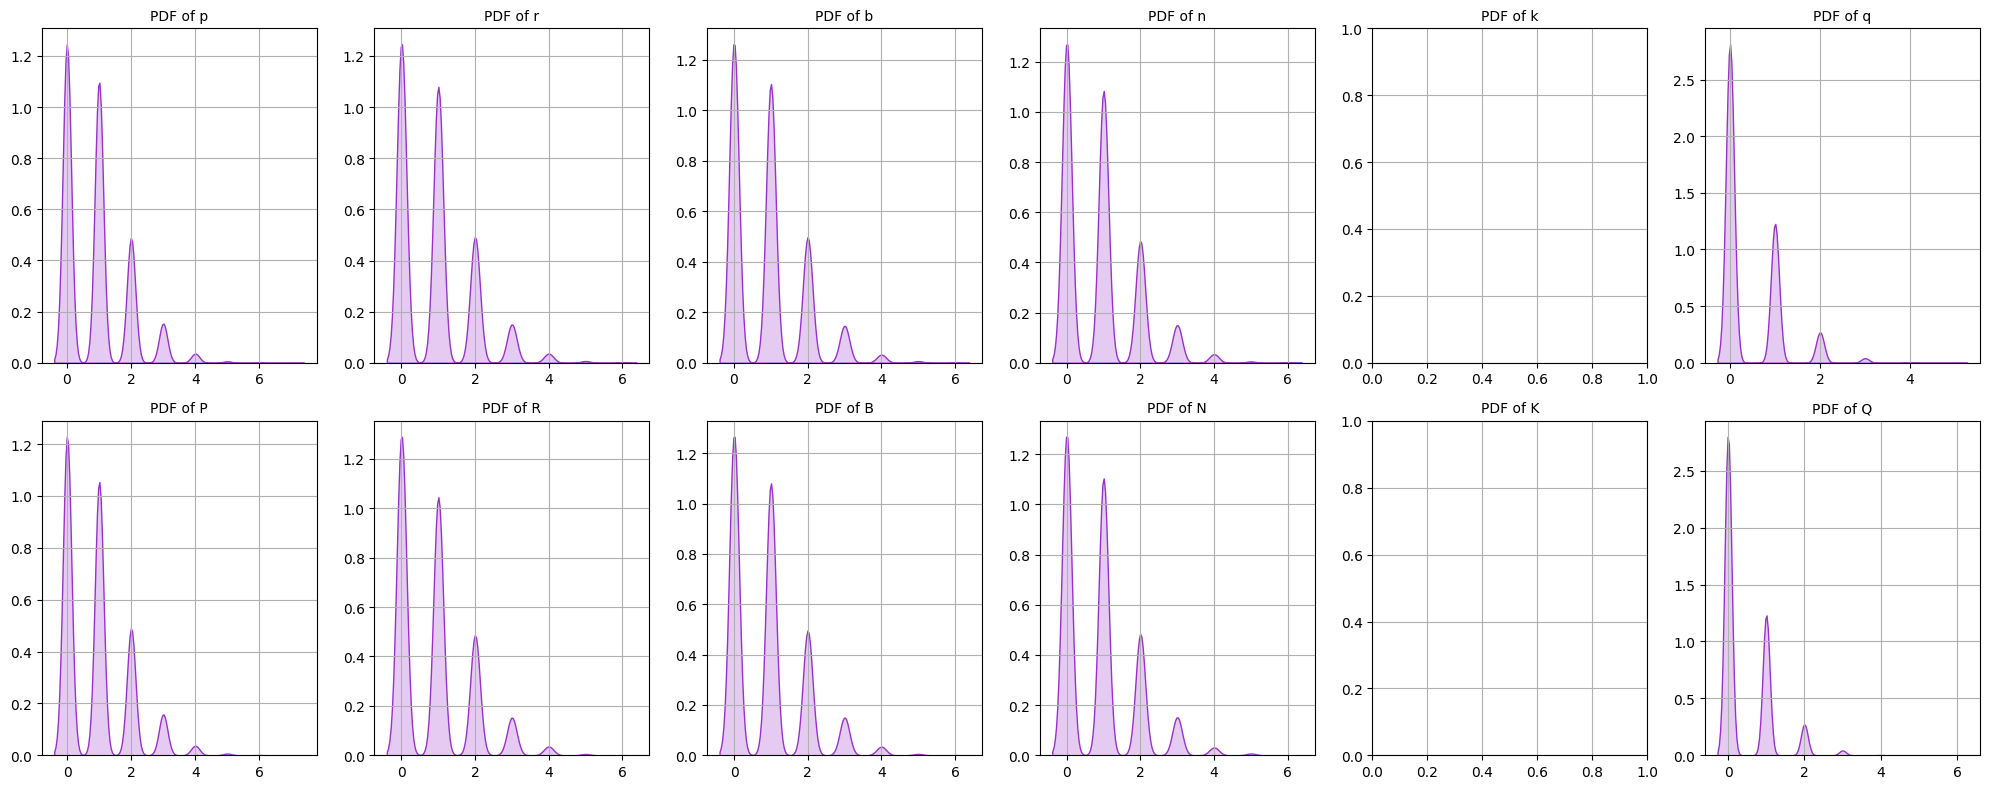

In [33]:
pdf_plotter(df=te_piece_df, features=list(piece_symbols))

Conclusion of above density plots:
1. There is only 1 Black king and 1 White King in all the boards.
2. The distribution of all pieces are almost similar. There are more boards with 0 pawns or 0 rooks or 0 knights or 0 bishops or 0 queens.

In [34]:
tr_chess_total_board_wise = tr_piece_df[list(piece_symbols)].sum(axis=1).to_frame().rename(columns={0: 'Total Board-Wise'})

In [35]:
te_chess_total_board_wise = te_piece_df[list(piece_symbols)].sum(axis=1).to_frame().rename(columns={0: 'Total Board-Wise'})

In [36]:
display(tr_chess_total_board_wise.describe().T)

count       mean       std  min  25%   50%   75%   max
Total Board-Wise  80000.0  10.005325  3.161312  5.0  7.0  10.0  13.0  15.0

In [37]:
display(te_chess_total_board_wise.describe().T)

count    mean       std  min  25%   50%   75%   max
Total Board-Wise  20000.0  9.9828  3.152174  5.0  7.0  10.0  13.0  15.0

In [38]:
def board_wise_distribution(tr_df, te_df, col):
    """
    This function plots the distribution of given data[label].
    """
    plt.figure(figsize=(15, 6))

    tr_df = tr_df.sort_values(by=[col])
    plt.subplot(121)
    plt.hist(x=tr_df[col].values, edgecolor='k', color='peachpuff', rwidth=0.8)
    plt.title(label='Histogram of {} - Train'.format(col), fontsize=10)
    plt.ylabel(ylabel='Number of Boards')
    plt.xlabel(xlabel='Total Pieces in a Board')

    te_df = te_df.sort_values(by=[col])
    plt.subplot(122)
    plt.hist(x=te_df[col].values, edgecolor='k', color='peachpuff', rwidth=0.8)
    plt.title(label='Histogram of {} - Test'.format(col), fontsize=10)
    plt.ylabel(ylabel='Number of Boards')
    plt.xlabel(xlabel='Total Pieces in a Board')
    
    plt.show()

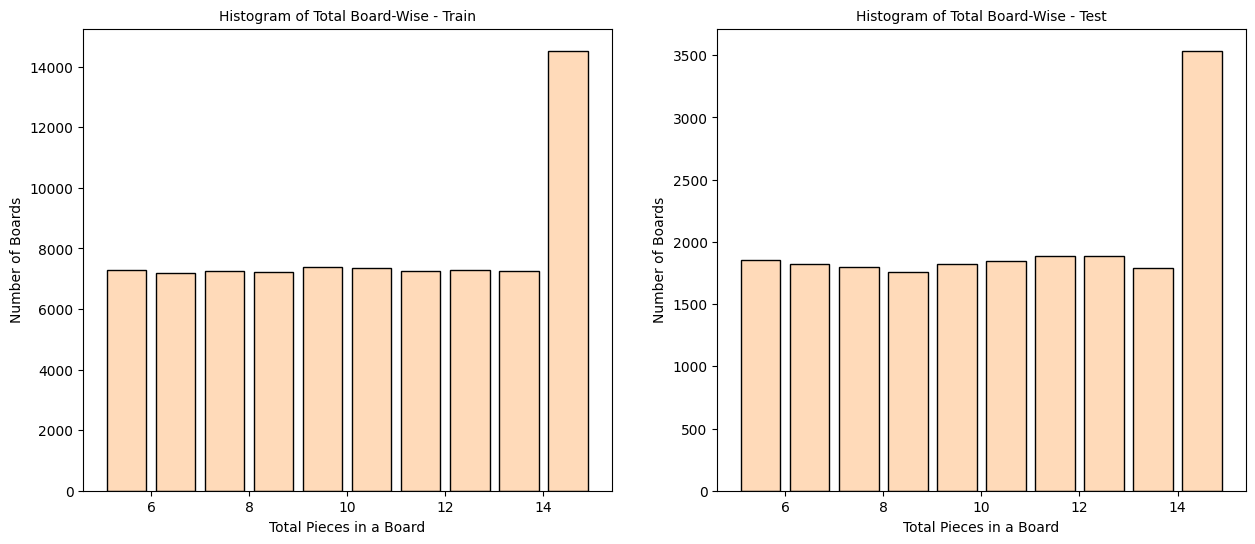

In [39]:
board_wise_distribution(tr_df=tr_chess_total_board_wise, te_df=te_chess_total_board_wise, col='Total Board-Wise')

Conclusion of above board wise pieces distribution plot:
1. Maximum number of pieces are 15.
2. Minimum number of pieces are 5.
3. Majority of boards are filled by 15 pieces.

Legal and illegal positioning of chess pieces

In [40]:
def construct_legal_illegal_chess_df(df):
    """
    This function returns a list of all illegal chess positioning image labels.
    """
    labels = df['label'].values
    images = df['image'].values
    
    legal_ind, illegal_ind = list(), list()
    for (i, label) in enumerate(labels):
        obj = IllegalPosition(fen_label=label)
        if obj.is_illegal():
            illegal_ind.append(i)
        else:
            legal_ind.append(i)
    
    legal_ind, illegal_ind = np.array(legal_ind), np.array(illegal_ind)
    
    legal_df = pd.DataFrame()
    legal_df['image'] = images[legal_ind]
    legal_df['label'] = labels[legal_ind]
    
    illegal_df = pd.DataFrame()
    illegal_df['image'] = images[illegal_ind]
    illegal_df['label'] = labels[illegal_ind]
    
    return legal_df, illegal_df

In [41]:
legal_tr_df, illegal_tr_df = construct_legal_illegal_chess_df(df=tr_df)
legal_te_df, illegal_te_df = construct_legal_illegal_chess_df(df=te_df)

In [42]:
total_tr = len(tr_df)

legal_tr_count = len(legal_tr_df)
illegal_tr_count = len(illegal_tr_df)

percent_tr_legal = round((legal_tr_count / total_tr) * 100, 1)
percent_tr_illegal = round((illegal_tr_count / total_tr) * 100, 1)

In [43]:
total_te = len(te_labels)

legal_te_count = len(legal_te_df)
illegal_te_count = len(illegal_te_df)

percent_te_legal = round((legal_te_count / total_te) * 100, 1)
percent_te_illegal = round((illegal_te_count / total_te) * 100, 1)

In [44]:
print(f"Legal training chess positions count: {legal_tr_count} ({percent_tr_legal}%).")
print(f"Illegal training chess positions count: {illegal_tr_count} ({percent_tr_illegal}%).")

Legal training chess positions count: 67813 (84.8%).
Illegal training chess positions count: 12187 (15.2%).


In [45]:
print(f"Legal testing chess positions count: {legal_te_count} ({percent_te_legal}%).")
print(f"Illegal testing chess positions count: {illegal_te_count} ({percent_te_illegal}%).")

Legal testing chess positions count: 17019 (85.1%).
Illegal testing chess positions count: 2981 (14.9%).


Checks by a chess piece on legal positions

In [46]:
def construct_check_df(fen_labels, defendant='K'):
    """
    This method in how many boards the king is under attack.
    """
    r, n, b, q, p = 'r', 'n', 'b', 'q', 'p'
    r_count, n_count, b_count, q_count, p_count = 0, 0, 0, 0, 0
    
    if defendant.isupper():
        title = "WHITE KING"
    elif defendant.islower():
        r, n, b, q, p = r.upper(), n.upper(), b.upper(), q.upper(), p.upper()
        title = "BLACK KING"
    
    for fen_label in fen_labels:
        obj = Check(fen_label=fen_label)
        if obj.rook_checks_king(attacker=r, defendant=defendant):
            r_count += 1
        if obj.knight_checks_king(attacker=n, defendant=defendant):
            n_count += 1
        if obj.bishop_checks_king(attacker=b, defendant=defendant):
            b_count += 1
        if obj.queen_checks_king(attacker=q, defendant=defendant):
            q_count += 1
        if obj.pawn_checks_king(attacker=p, defendant=defendant):
            p_count += 1
    
    check_df = pd.DataFrame()
    check_df["ROOK"] = [r_count]
    check_df["KNIGHT"] = [n_count]
    check_df["BISHOP"] = [b_count]
    check_df["QUEEN"] = [q_count]
    check_df["PAWN"] = [p_count]
    check_df = check_df.T.rename(columns={0: f"{title}"})
    
    return check_df

In [47]:
def plot_check_distribution(check_df, title):
    """
    This function plots the check distribution.
    """
    cols = list(check_df.columns)
    
    plt.figure(figsize=(15, 7))
    for i, col in zip(range(1, len(cols)+1), cols):
        plt.subplot(int(f"12{i}"))
        bars = sns.barplot(x=check_df.index, y=check_df[col])
        for b in bars.patches:
            x = b.get_x() + (b.get_width() / 2)
            y = b.get_height()
            bars.annotate(text=format(y),
                          xy=(x, y), ha='center', va='center', size=8, 
                          xytext=(0, 6), textcoords='offset points')
        plt.title(label=f'{title} Check Distribution - {col}', fontsize=10)
        plt.ylabel(ylabel=None)
    plt.show()

In [48]:
K_check_tr_df = construct_check_df(fen_labels=legal_tr_df['label'].values, defendant='K')
k_check_tr_df = construct_check_df(fen_labels=legal_tr_df['label'].values, defendant='k')

In [49]:
check_tr_df = pd.merge(left=K_check_tr_df, right=k_check_tr_df, left_index=True, right_index=True)
display(check_tr_df)

WHITE KING  BLACK KING
ROOK          7010        6817
KNIGHT        3276        3373
BISHOP        4557        4500
QUEEN         5809        5827
PAWN          2462        2398

In [50]:
K_check_te_df = construct_check_df(fen_labels=legal_te_df['label'].values, defendant='K')
k_check_te_df = construct_check_df(fen_labels=legal_te_df['label'].values, defendant='k')

In [51]:
check_te_df = pd.merge(left=K_check_te_df, right=k_check_te_df, left_index=True, right_index=True)
display(check_te_df)

WHITE KING  BLACK KING
ROOK          1713        1693
KNIGHT         858         850
BISHOP        1151        1105
QUEEN         1374        1445
PAWN           590         623

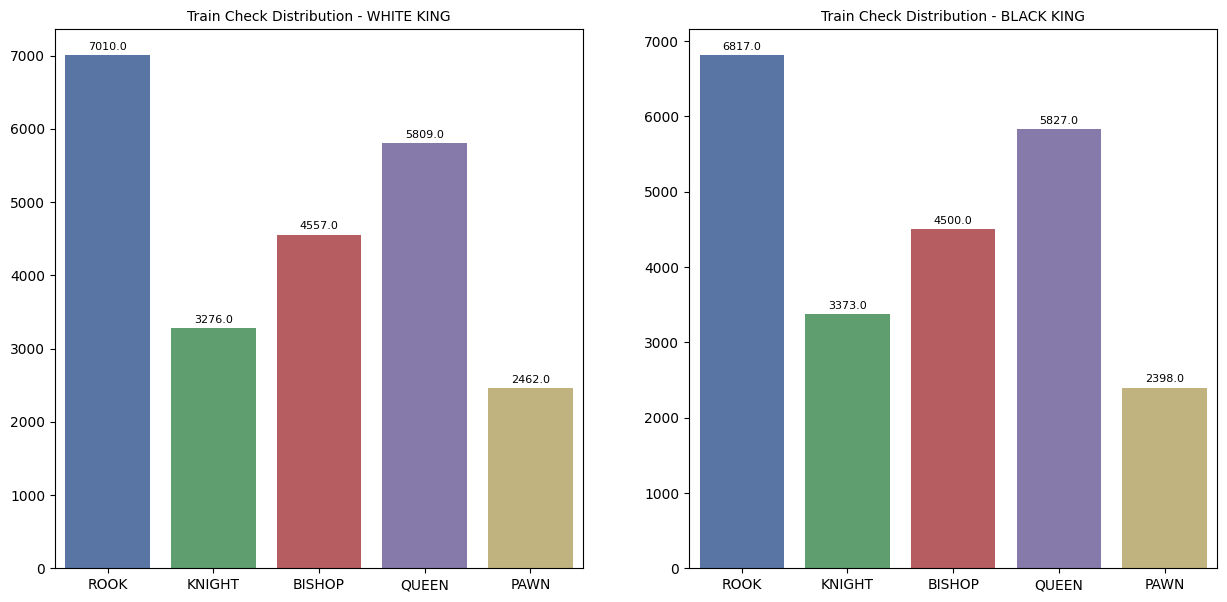

In [52]:
plot_check_distribution(check_df=check_tr_df, title='Train')

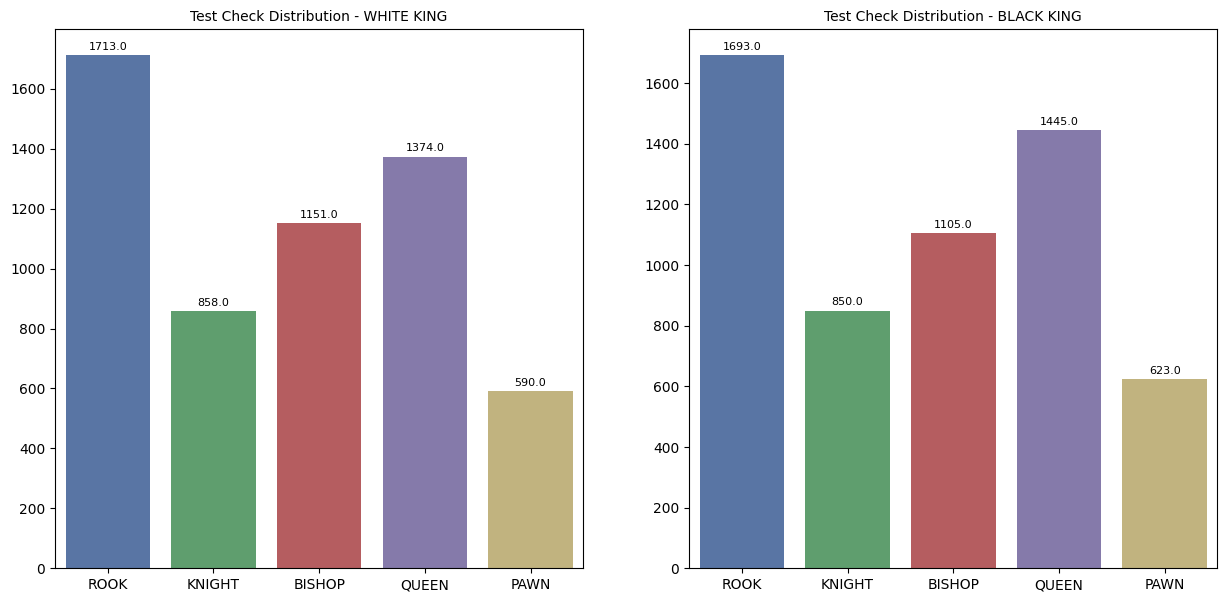

In [53]:
plot_check_distribution(check_df=check_te_df, title='Test')

Plotting the chess images

In [54]:
def plot_sample_images(df, convert_to_gray=False):
    """
    This function plots the 16 random images.
    """
    sample = df.sample(n=9, random_state=10)
    
    images_path = sample['image'].values
    labels = sample['label'].values

    fig = plt.figure(figsize=(12, 12))
    for (i, img_path, lbl) in zip(range(len(labels)), images_path, labels):
        fig.add_subplot(3, 3, i+1)
        img = cv.imread(filename=img_path)
        if convert_to_gray:
            plt.imshow(X=cv.cvtColor(src=img, code=cv.COLOR_BGR2GRAY))
        else:
            plt.imshow(X=cv.cvtColor(src=img, code=cv.COLOR_BGR2RGB))
        plt.title(label="FEN: {}".format(lbl), fontsize=10)
        plt.axis('off')
        plt.tight_layout()
        i += 1
    plt.show()

Legal chess plots for train and test sets

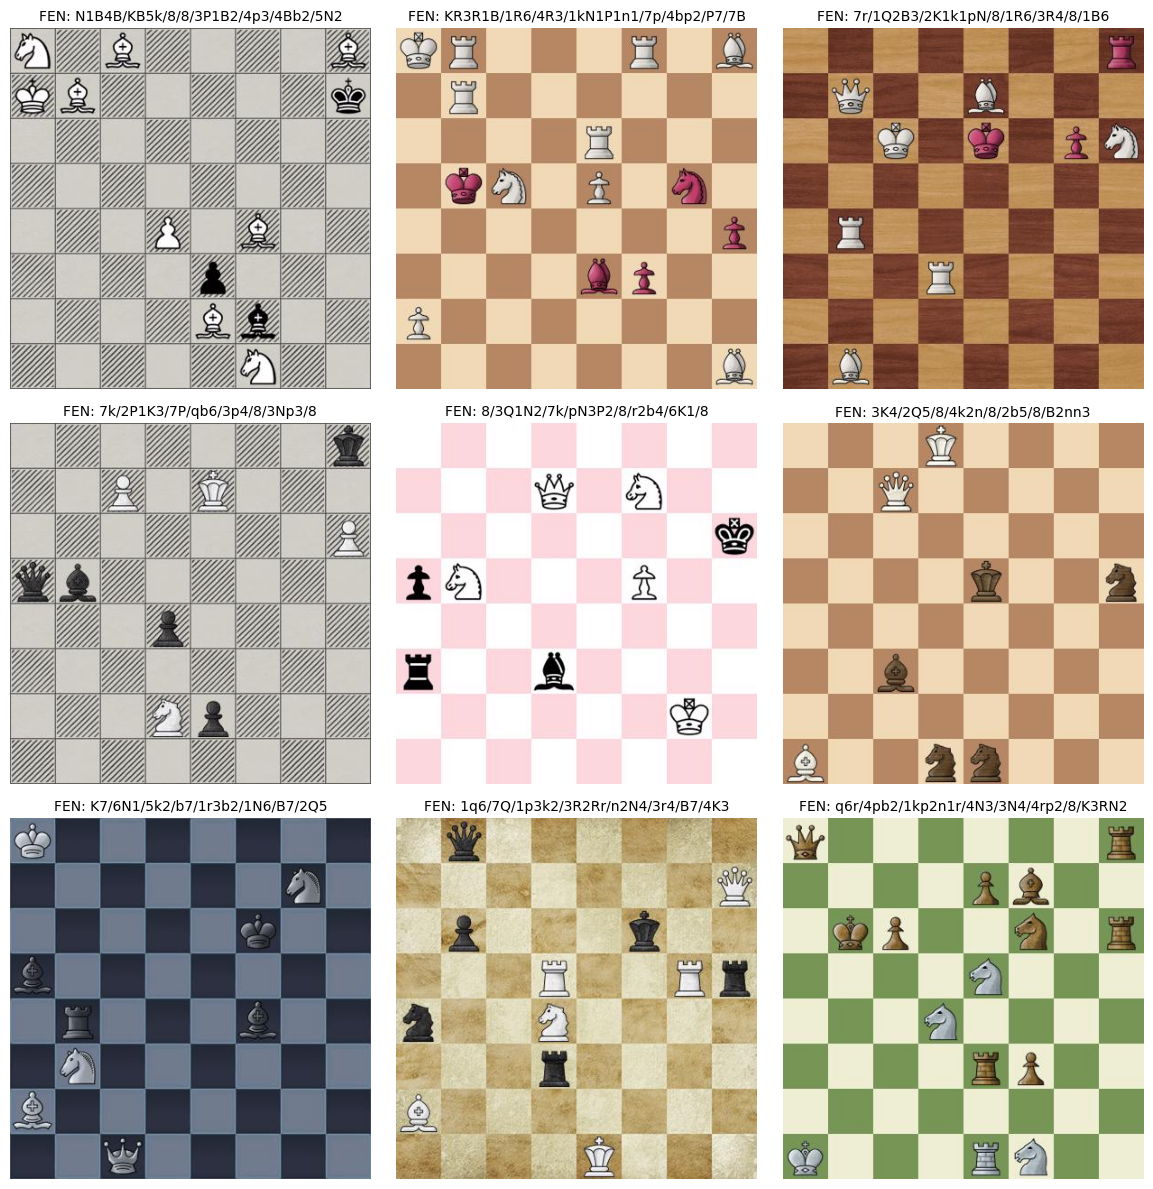

In [55]:
plot_sample_images(df=legal_tr_df)

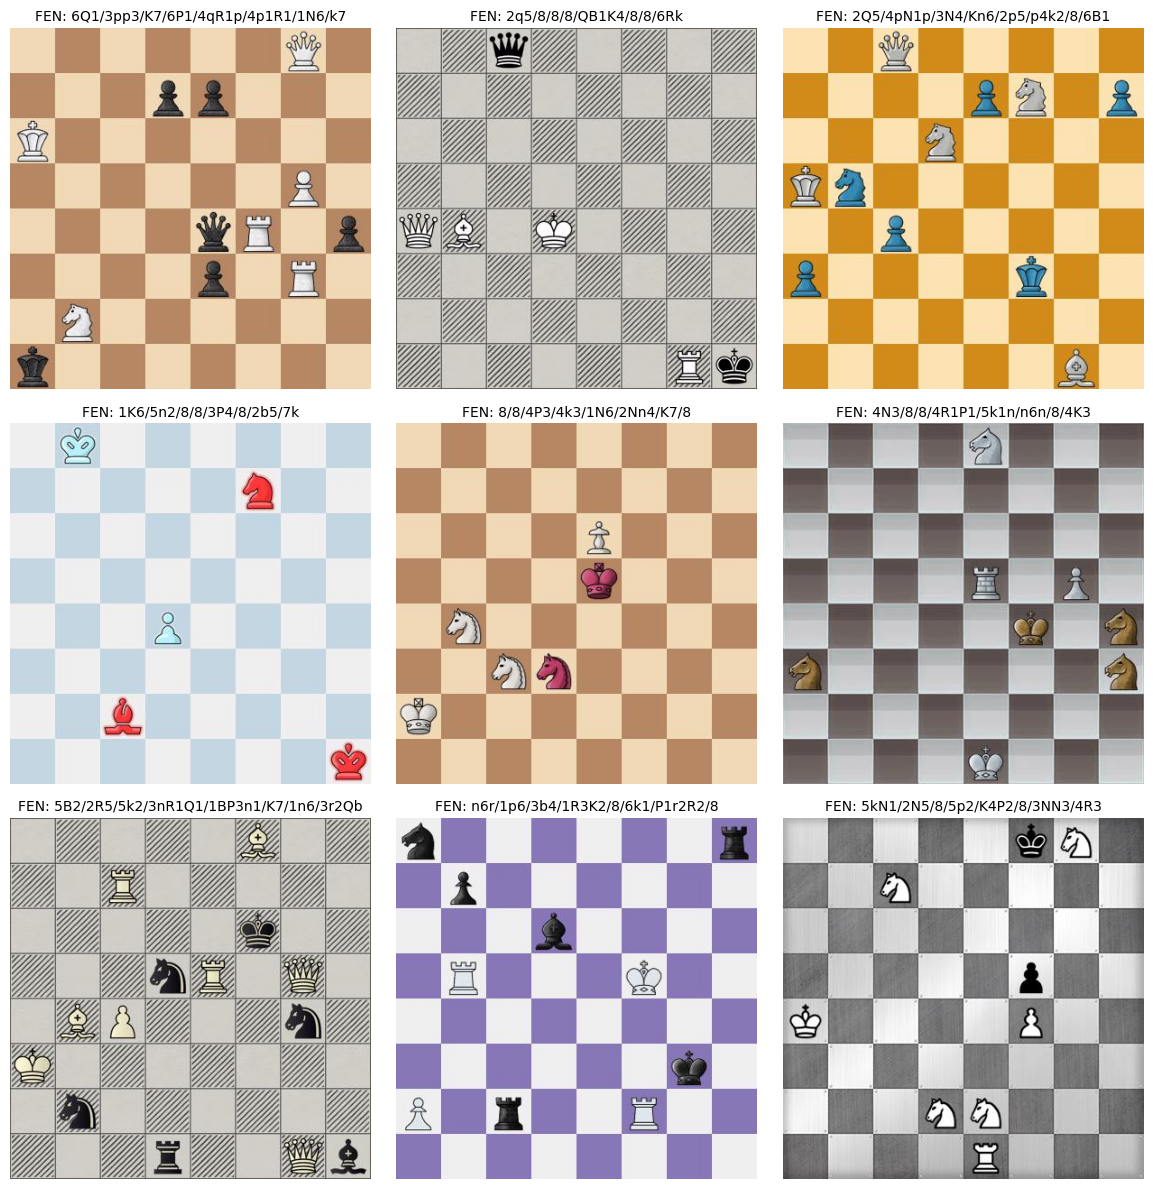

In [56]:
plot_sample_images(df=legal_te_df)

Illegal chess plots for train and test sets

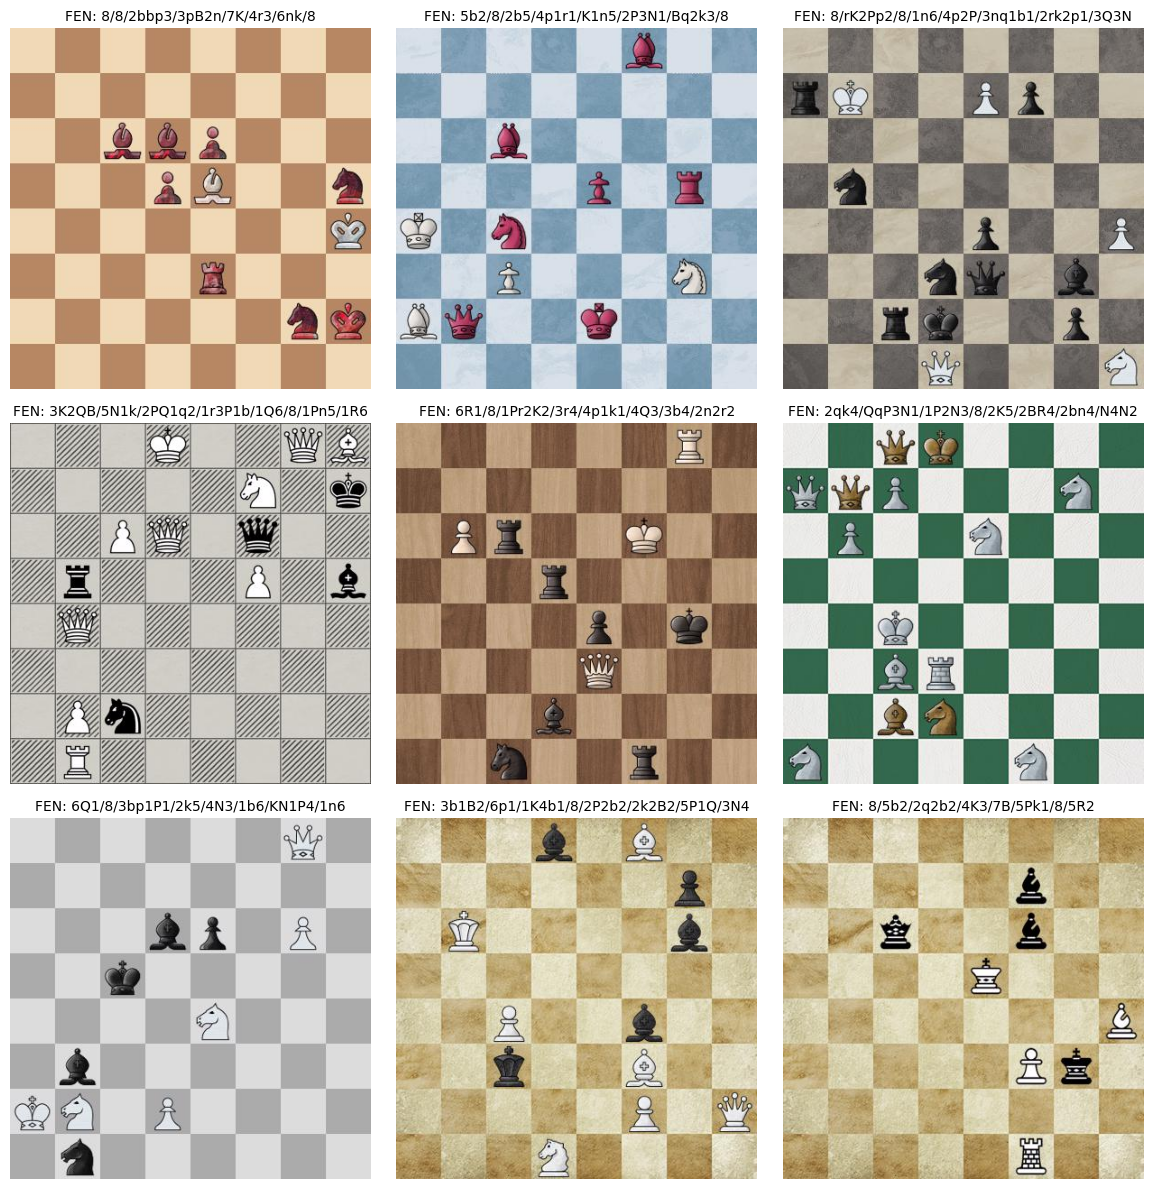

In [57]:
plot_sample_images(df=illegal_tr_df)

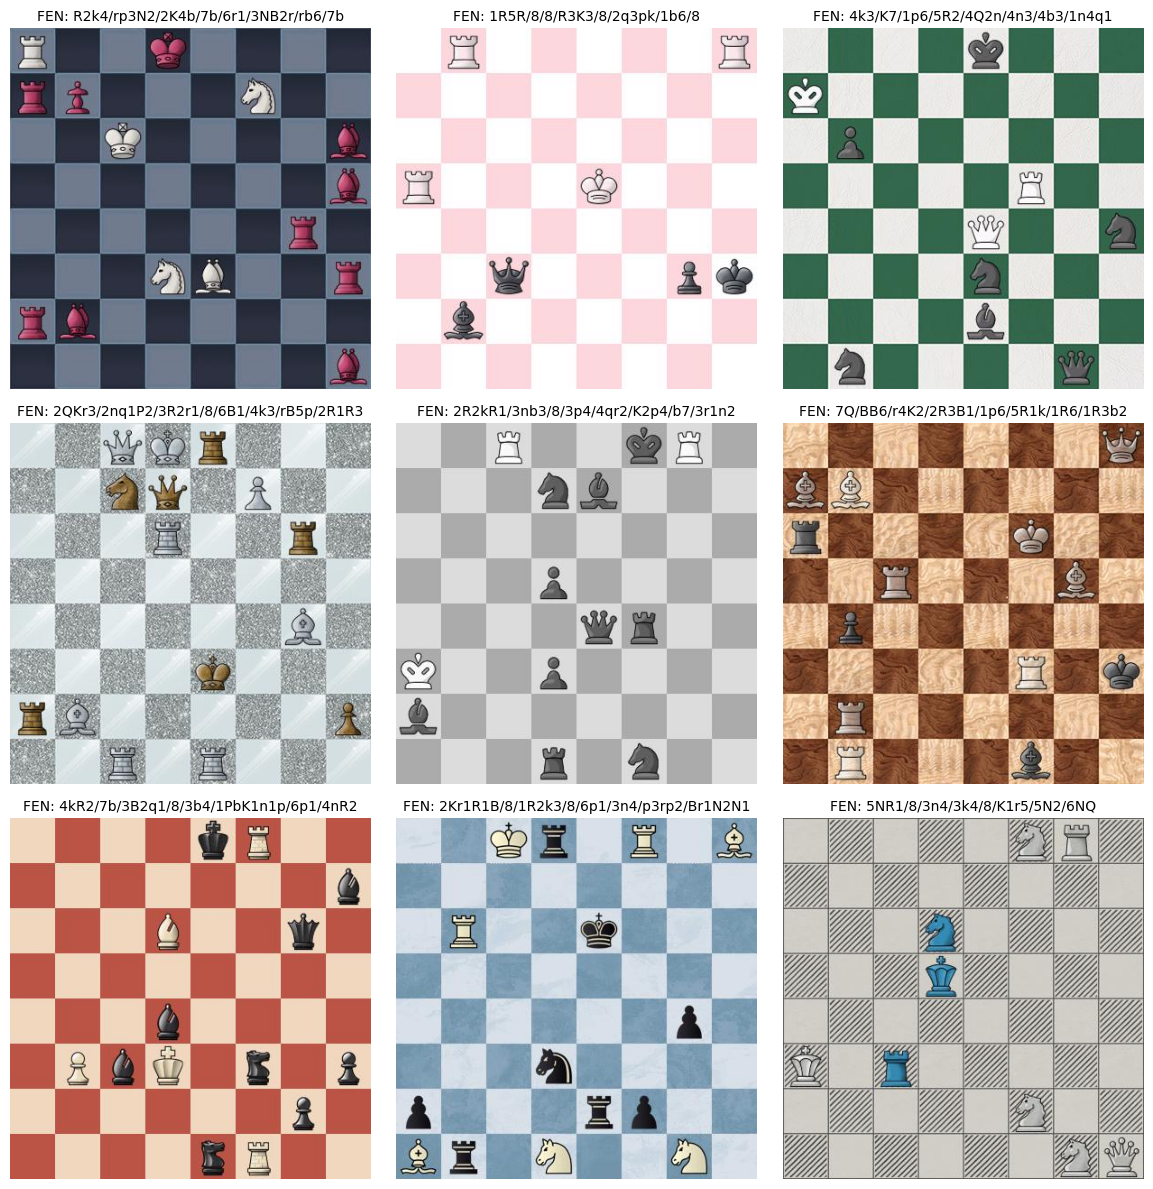

In [58]:
plot_sample_images(df=illegal_te_df)

Size of all images - ratio, height, and width

Ratio: https://www.adobe.com/express/discover/sizes/photo-aspect-ratio

In [59]:
def get_image_size_ratio(images):
    """
    This function obtains the sizes of the images.
    """
    ratios, heights, widths = list(), list(), list()
    for image in tqdm(images):
        img = cv.imread(filename=image)
        ratios.append(img.shape[1] / img.shape[0])
        heights.append(img.shape[0])
        widths.append(img.shape[1])
    return ratios, heights, widths

In [60]:
def plot_images_size(tr_df, te_df):
    """
    This function plots the size of the images.
    """
    tr_images = tr_df['image'].values
    te_images = te_df['image'].values

    tr_r, tr_h, tr_w = get_image_size_ratio(images=tr_images)
    te_r, te_h, te_w = get_image_size_ratio(images=te_images)
    
    titles = ['Train Images Ratio', 'Train Images Height', 'Train Images Width',
              'Test Images Ratio', 'Test Images Height', 'Test Images Width']
    configs = [tr_r, tr_h, tr_w, te_r, te_h, te_w]
    colors = ['b', 'r', 'g'] * 2
    
    print()

    plt.figure(figsize=(15, 8))
    for (i, config, c, t) in zip(range(1, len(colors)+1), configs, colors, titles):
        plt.subplot(int(f"23{i}"))
        plt.hist(x=config, color=c)
        plt.title(label=t)
        plt.tight_layout()
    plt.show()

100%|████████████████████████████████████████████████████████████| 20000/20000 [00:22<00:00, 871.00it/s]


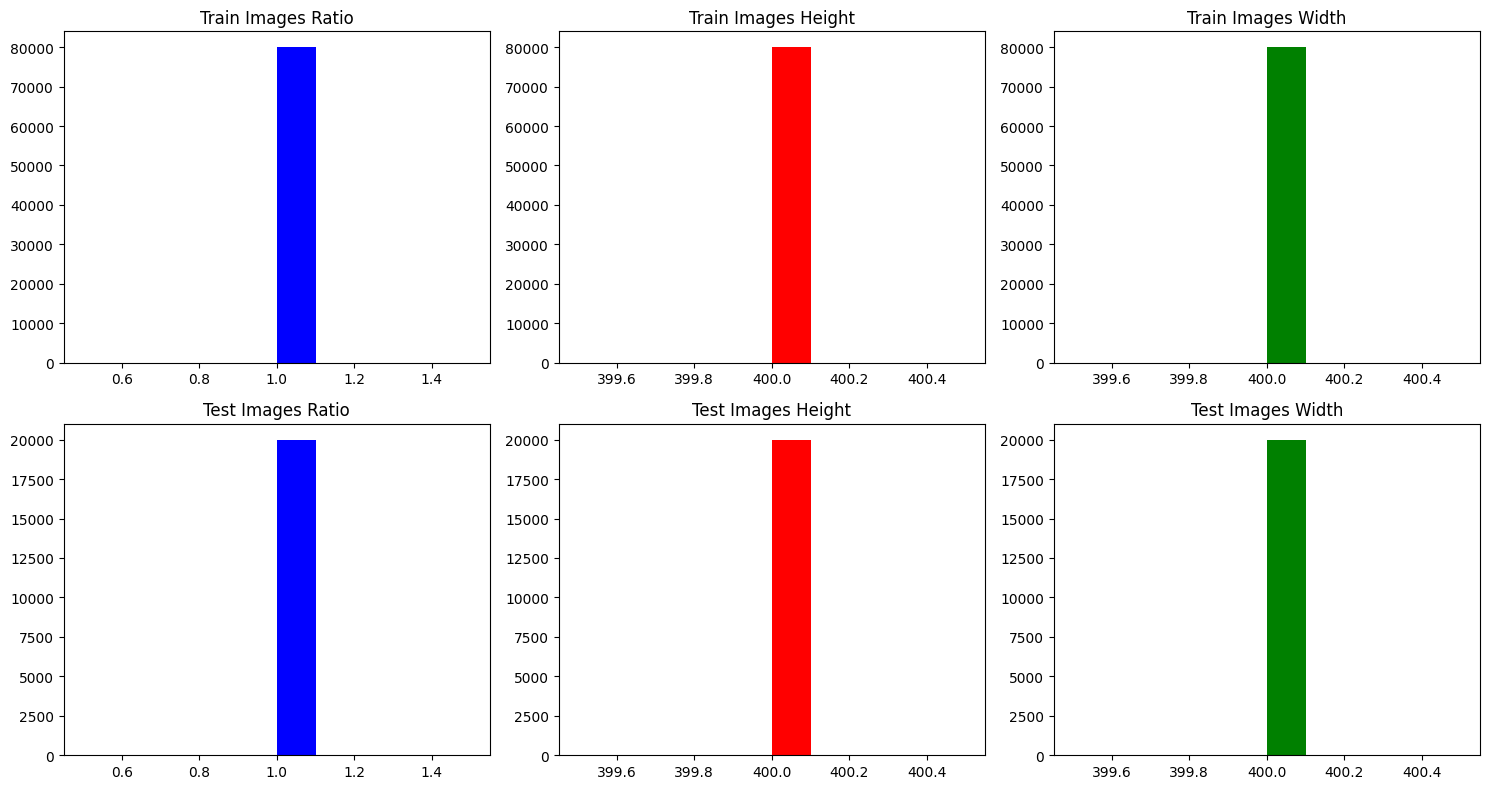

In [61]:
plot_images_size(tr_df=tr_df, te_df=te_df)

Conclusion of above image sizes plot:
1. Ratio = Height / Width --> 1.
    - All images have same ratio i.e., 1.
2. All images have same width i.e., 400 pixels.
3. All images have same height i.e., 400 pixels.